In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages


plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
# List to store all DataFrames
dfs = []

folder_path = '../results/round_metrics'

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file)
        # Load the CSV file into a DataFrame and append it to the list
        dfs.append(pd.read_csv(file_path, index_col=0))

In [3]:
df =  pd.concat(dfs, ignore_index=True)

In [4]:
df['accuracy'] = 100 * df['accuracy'].round(4)
df['f1'] = 100 * df['f1'].round(4)

In [5]:
df['server_opt_lr_log10'] = np.log10(df['server_opt_lr']).round(1)
df['client_opt_lr_log10'] = np.log10(df['client_opt_lr']).round(1)

In [6]:
def filter_unique_test(df, checkpoint, ds_path, ds_name, alpha, batch_size, num_clients, clients_per_round, fda):
    return df[
        (df['checkpoint'] == checkpoint) &
        (df['ds_path'] == ds_path) &
        (df['ds_name'] == ds_name) &
        (df['alpha'] == alpha) &
        (df['batch_size'] == batch_size) &
        (df['num_clients'] == num_clients) &
        (df['clients_per_round'] == clients_per_round) &
        (df['fda'] == fda)
    ]

In [7]:
def filter_fed_opt(df, algo, **extra):
    if algo == 'FedAdam':
        return df[
            (df['server_opt_name'] == 'Adam') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvg':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'].isna())
        ]
    if algo =='FedYogi':
        return df[
            (df['server_opt_name'] == 'Yogi') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvgM':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'] == extra['server_opt_momentum'])
        ]
    if algo == 'FedAdagrad':
        return df[
            (df['server_opt_name'] == 'Adagrad') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAdamW':
        return df[
            (df['server_opt_name'] == 'AdamW') &
            (df['client_opt_name'] == 'SGD')
        ]

In [8]:
def learning_rate_grid(df, algo, round_num, ds_name, **extras):
    
    df_algo = filter_fed_opt(df, algo, **extras)
    df_algo_round = df_algo[df_algo['round'] == round_num]
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values='accuracy')

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/{ds_name}_{algo}_{round_num}.pdf')

    # Create the plot
    plt.figure(figsize=(7.5, 7))
    #plt.figure(figsize=(6, 5))
    #plt.figure(figsize=(8, 6))

    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        vmin=30,
        vmax=90
    )


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Accuracy')

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    plt.title(f'{ds_name}, {algo}')
    
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

## MRPC

In [9]:
df_mrpc = filter_unique_test(
    df, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=False
)

In [10]:
learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)

In [11]:
learning_rate_grid(df, 'FedAdam', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)

In [12]:
learning_rate_grid(df, 'FedAdamW', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)

In [13]:
learning_rate_grid(df, 'FedAvg', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)

## Variance

In [14]:
def plot_variance(df, log, algo):
    df = df[df['round'] <= 100]
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(df['round'], df['variance'], marker='o', linestyle='-', label='Variance')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Variance')
    
    if log: plt.yscale('log')

    # Add a title
    plt.title(algo)

    # Add a legend
    plt.legend()

    plt.show()
    
    print(df['variance'].describe())

## FedAdam

In [15]:
df_adam = filter_fed_opt(df, 'FedAdam')
df_adam = df_adam[(df_adam['server_opt_lr_log10'] == -4) & (df_adam['client_opt_lr_log10'] == -4)]

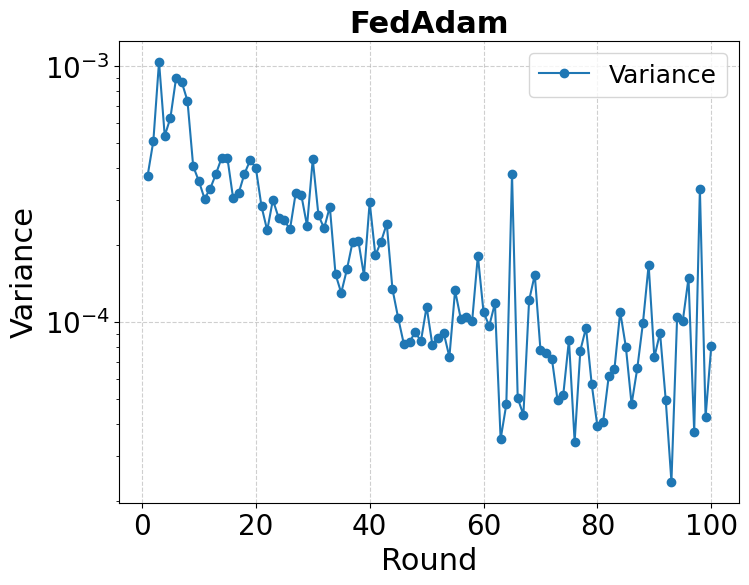

count    100.000000
mean       0.000210
std        0.000194
min        0.000024
25%        0.000080
50%        0.000131
75%        0.000301
max        0.001042
Name: variance, dtype: float64


In [16]:
plot_variance(df_adam, True, 'FedAdam')

In [21]:
df_adam['accuracy'][:20]

300    68.38
301    68.38
302    68.38
303    68.38
304    68.38
305    70.83
306    71.32
307    72.06
308    62.75
309    73.77
310    81.62
311    82.60
312    83.58
313    85.54
314    86.52
315    88.24
316    87.01
317    85.78
318    84.56
319    84.07
Name: accuracy, dtype: float64

## FedAdamW

In [164]:
df_adamw = filter_fed_opt(df, 'FedAdamW')
df_adamw = df_adamw[(df_adamw['server_opt_lr_log10'] == -5) & (df_adamw['client_opt_lr_log10'] == -3)]

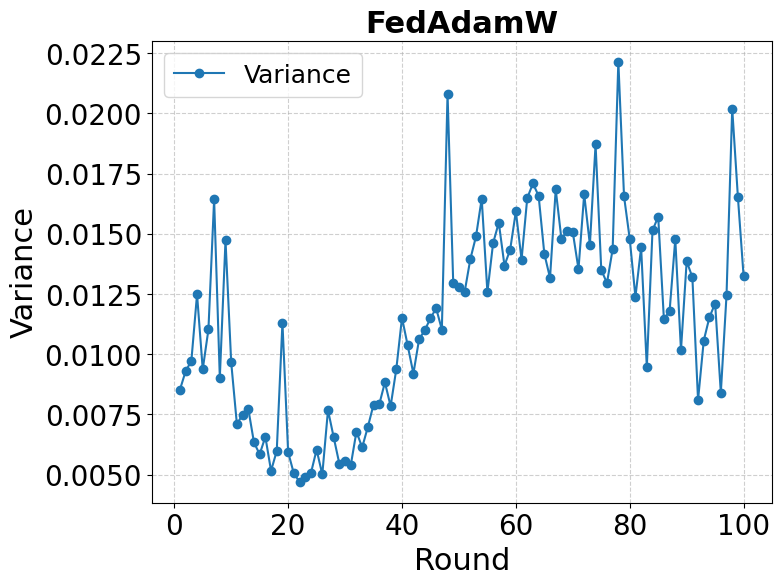

count    100.000000
mean       0.011476
std        0.004055
min        0.004709
25%        0.007914
50%        0.011662
75%        0.014563
max        0.022143
Name: variance, dtype: float64


In [165]:
plot_variance(df_adamw, False, 'FedAdamW')

## FedAvg

In [166]:
df_avg = filter_fed_opt(df, 'FedAvg')
df_avg = df_avg[(df_avg['server_opt_lr_log10'] == 0) & (df_avg['client_opt_lr_log10'] == -3)]

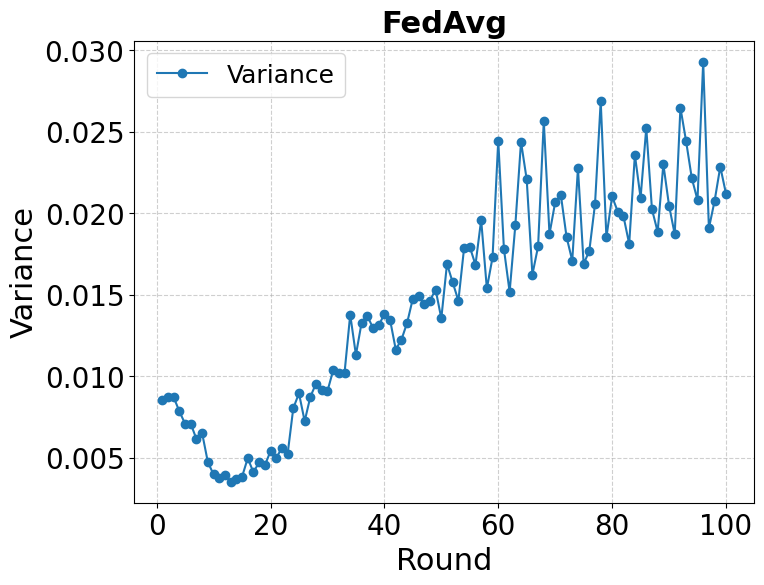

count    100.000000
mean       0.014607
std        0.006671
min        0.003536
25%        0.008749
50%        0.015031
75%        0.019873
max        0.029278
Name: variance, dtype: float64


In [167]:
plot_variance(df_avg, False, 'FedAvg')

## FedAvgM

In [168]:
df_avgm = filter_fed_opt(df, 'FedAvg', momentum=0.9)
df_avgm = df_avgm[(df_avgm['server_opt_lr_log10'] == 0) & (df_avgm['client_opt_lr_log10'] == -4)]

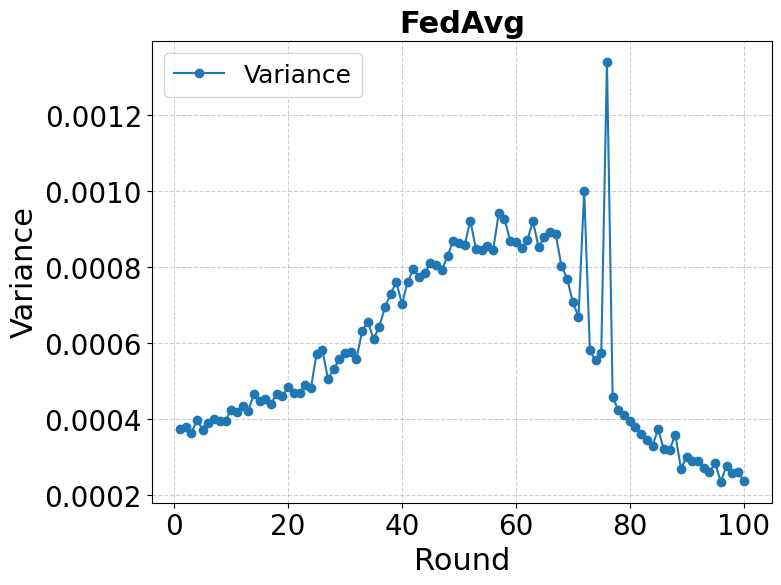

count    100.000000
mean       0.000580
std        0.000232
min        0.000236
25%        0.000394
50%        0.000544
75%        0.000797
max        0.001341
Name: variance, dtype: float64


In [169]:
plot_variance(df_avgm, False, 'FedAvg')

In [1]:
import torch

@torch.no_grad
def copy_parameters(from_params, to_params):
    """
    Copies the values from one set of parameters to another.

    This function operates in-place and modifies the `to_parameters` directly.
    The @torch.no_grad() decorator ensures that this operation is not tracked
    by autograd, preventing unnecessary computation and memory usage.

    Args:
        from_params (list of torch.nn.Parameter): An iterable of source parameters to copy from.
        to_params (list of torch.nn.Parameter): An iterable of destination parameters to copy to.
    """
    for from_param, to_param in zip(from_params, to_params):
        device = to_param.device
        to_param.copy_(from_param.to(device))

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

In [18]:
model1 = AutoModelForSequenceClassification.from_pretrained('roberta-base',num_labels=2).to('cuda:0')
params1 = [param for param in model1.parameters() if param.requires_grad]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model2 = AutoModelForSequenceClassification.from_pretrained('roberta-base',num_labels=2).to('cuda:0')
params2 = [param for param in model2.parameters() if param.requires_grad]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import time

In [20]:
start = time.perf_counter()

copy_parameters(params1, params2)

end = time.perf_counter()

In [22]:
x = end - start

In [23]:
x

0.006615009158849716

In [24]:
x * 50 * 10 

3.307504579424858

In [16]:
time.perf_counter() - start

7.87344479188323

-8.67992639541626e-07